In [1]:
import os
import cv2
import math
import numpy as np
from time import time
import matplotlib.pyplot as plt
from preprocess import image_crop, image_back, residual

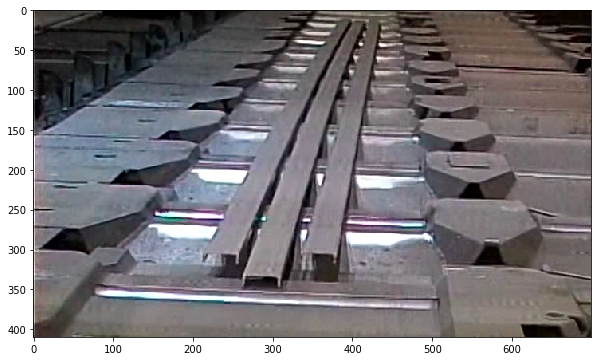

In [3]:
# target image
img_target = 'data/U100/5t_1740_彎曲_3支/frame0443.jpg'
# img_target = 'data/20200810_U100x50x3.8t_1518_直度ok_3支/frame0562.jpg'
img_target_ori = cv2.imread(img_target)
img_target = image_crop(img_target)
fig, ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
ax.imshow(img_target)
plt.show()

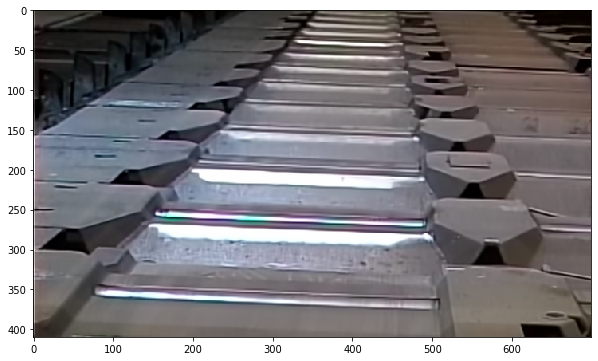

In [4]:
# background image
image_dir = 'data/U100/5t_1740_彎曲_3支'
image_paths = os.listdir(image_dir)
image_paths.sort()
image_paths = image_paths[:199]
image_paths = [os.path.join(image_dir, image_path) for image_path in image_paths]
img_list = image_crop(image_paths)
img_back = image_back(img_list)

fig, ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
ax.imshow(img_back.astype(np.uint8))
plt.show()

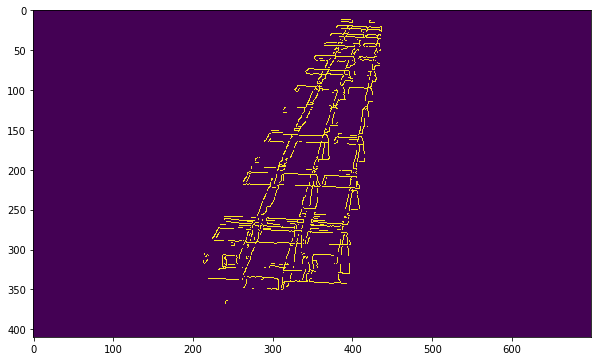

In [5]:
# residual image
img_residual, img_edage = residual(img_target_ori, img_back, 120, 200)

fig, ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
ax.imshow(img_edage.astype(np.uint8))
plt.show()

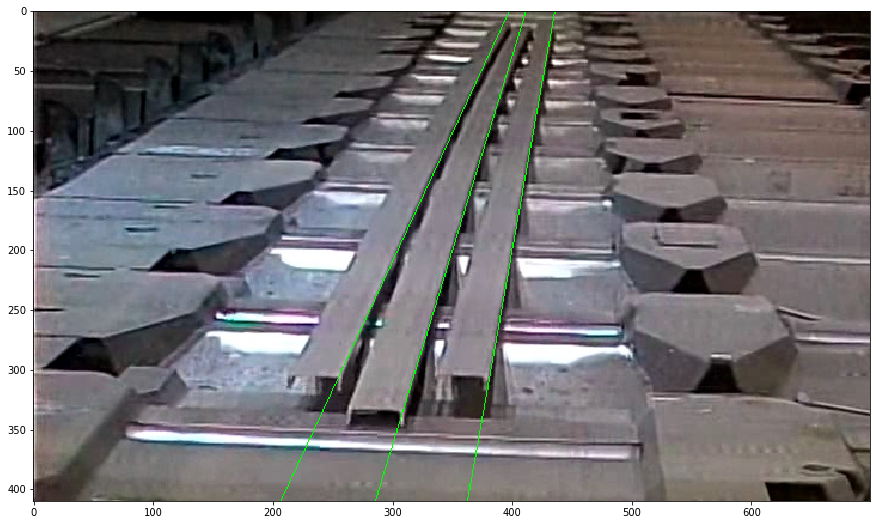

In [7]:
# method one: after the r and theta criteria
# use the iteration to run the threshold
# start from low to high until find minimum 5 line

lines = cv2.HoughLines(img_edage,1,np.pi/180,130)
    # dst: edge image. It should be a grayscale image
    # lines: A vector store (r,θ) of the detected lines
    # rho : The resolution of the parameter r in pixels. We use 1 pixel.
    # theta: The resolution of the parameter θ in radians. We use 1 degree (CV_PI/180)
    # threshold: The minimum number of intersections to "*detect*" a line
img = img_target.copy()
if lines is not None:
    lines = lines.squeeze()
    angle = [line[-1] for line in lines if line[-1] < 30 * np.pi/180]
    r = [line[0] for line in lines if line[-1] < 30 * np.pi/180]
    for i in range(0, len(angle)):
        rho = r[i]#lines[i][0][0]
        theta = angle[i]#lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        img_line = cv2.line(img, pt1, pt2, (0,255,0), 1)
else:
    raise IOError('No line detected')

fig, ax = plt.subplots(1,1)
fig.set_figheight(15)
fig.set_figwidth(15)
ax.imshow(img_line.astype(np.uint8))
plt.show()

In [21]:
lines = lines.squeeze()
r = [line[0] for line in lines]
theta = [line[-1]*180/np.pi for line in lines]
print(theta)
print(r)

[16.999999334703237, 9.99999970909292, 25.00000012650595, 22.000000043023345, 24.000000667860846, 91.99999800667379, 25.999999585151052, 15.999999876058132, 91.99999800667379, 9.000000250447817, 21.00000058437824, 11.000000021511672, 25.999999585151052, 26.99999904379616]
[394.0, 430.0, 361.0, 369.0, 368.0, 208.0, 366.0, 392.0, 328.0, 431.0, 365.0, 431.0, 360.0, 364.0]


# Try the cv denoising

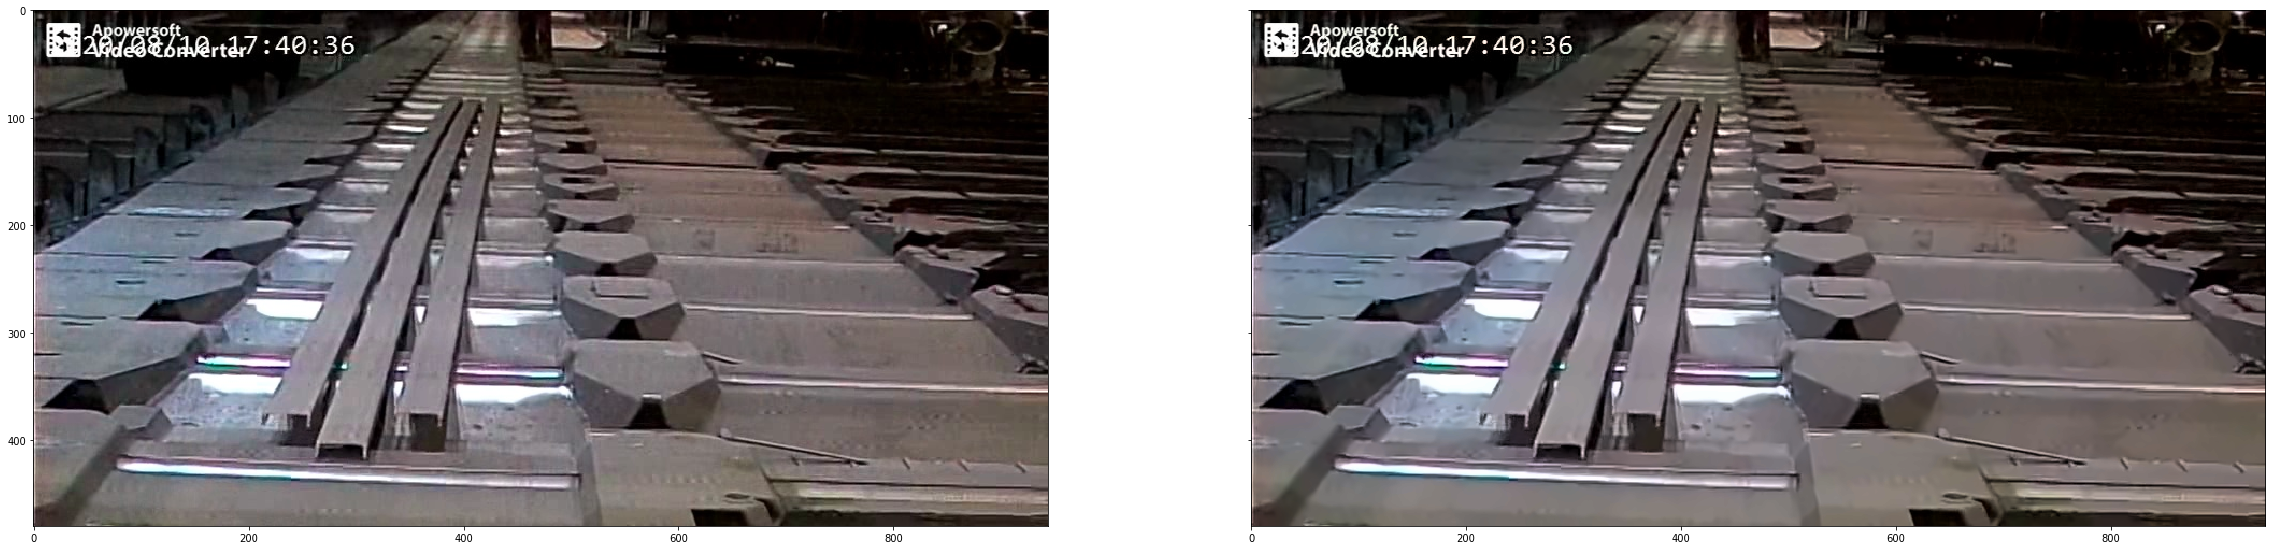

In [19]:
img_de = cv2.fastNlMeansDenoisingColored(img_target)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(40)
ax1.imshow(img_target)
ax2.imshow(img_de)
plt.show()


In [20]:
start_time = time()
img_de = cv2.fastNlMeansDenoisingColored(img_target)
print(time() - start_time)

0.3901994228363037


Even though, the noise indeed decrease, one image takes 0.3~0.4 sec to process

In [6]:
# Lower and enlarge kernal combine with OTSU method
# load color image
# im = cv2.imread(image_path)
im = img_residual.astype(np.uint8)

# smooth the image with alternative closing and opening
# with an enlarging kernel
morph = im.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# take morphological gradient
gradient_image = cv2.morphologyEx(morph, cv2.MORPH_GRADIENT, kernel)

# split the gradient image into channels
image_channels = np.split(np.asarray(gradient_image), 3, axis=2)

channel_height, channel_width, _ = image_channels[0].shape

# apply Otsu threshold to each channel
for i in range(0, 3):
    _, image_channels[i] = cv2.threshold(~image_channels[i], 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    image_channels[i] = np.reshape(image_channels[i], newshape=(channel_height, channel_width, 1))

# merge the channels
image_channels = np.concatenate((image_channels[0], image_channels[1], image_channels[2]), axis=2)

# save the denoised image
# cv2.imwrite('output.jpg', image_channels)

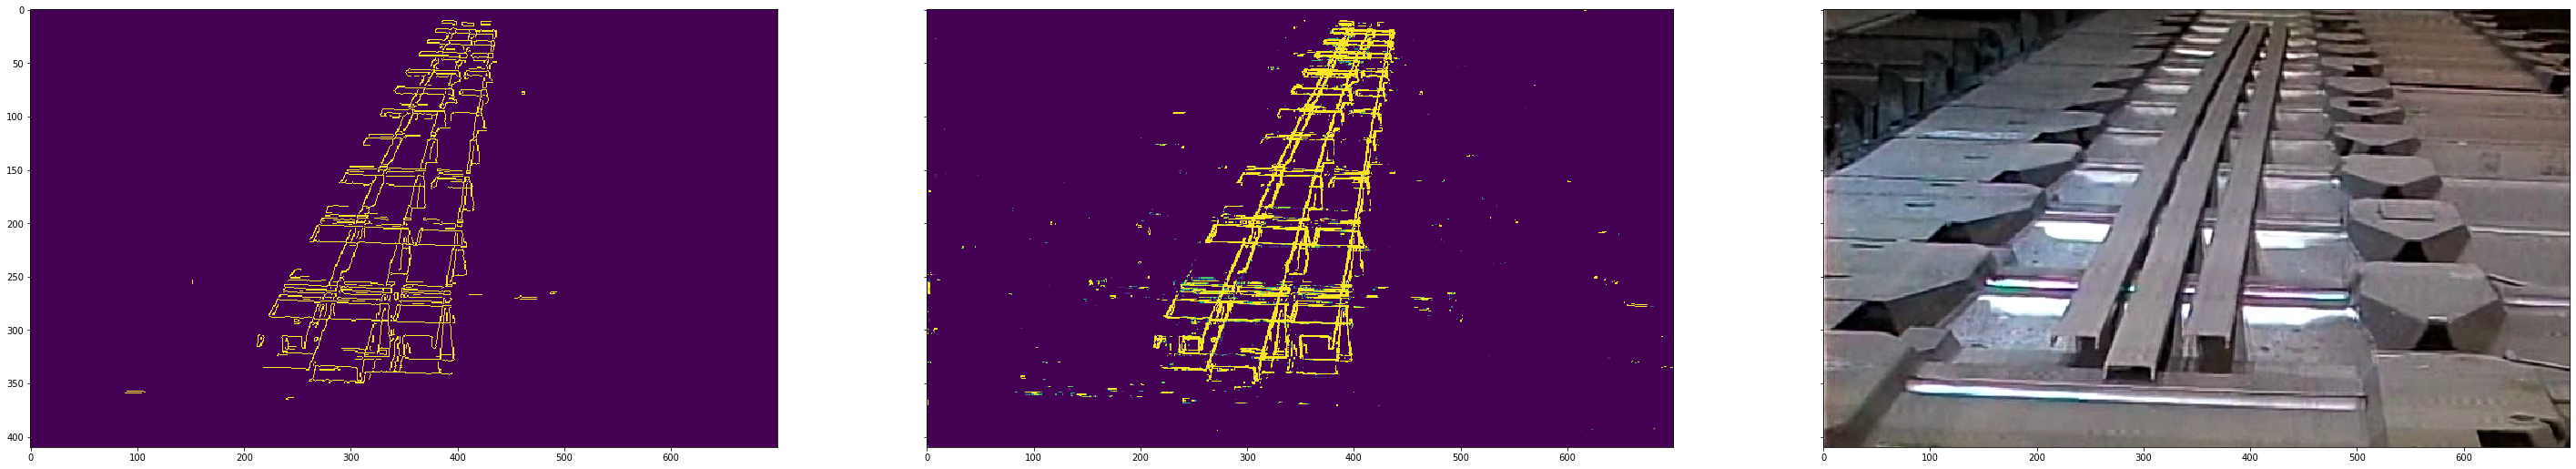

In [7]:
# TODO: we should make the dark to the white

img = image_crop(img_target)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)
fig.set_figheight(50)
fig.set_figwidth(50)
ax1.imshow(img_edage)
image_ostu = cv2.cvtColor(image_channels, cv2.COLOR_BGR2GRAY)
image_ostu = 255 - image_ostu
ax2.imshow(image_ostu)
ax3.imshow(img)
plt.show()

In [ ]:
img_edage

In [26]:
img = cv2.imread(img_target)
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(img_grey,127,255,cv2.THRESH_BINARY)
image, cnts= cv2.findContours(binary, cv2.CV_RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
img = cv2.drawContours(img,[cnts[0]],-1,(0,255,0),10)


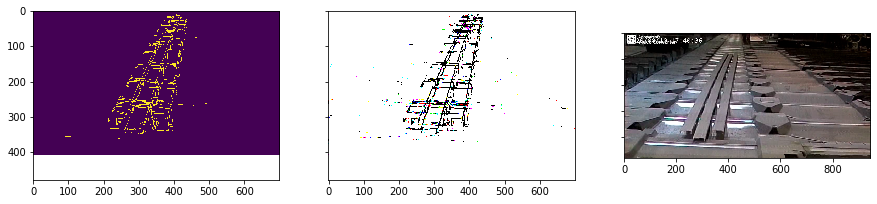

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(img_edage)
ax2.imshow(image_channels)
ax3.imshow(img)
plt.show()

In [1]:
import os
import shutil

In [2]:
train_image_path = 'data/clean_data_20frames/U100/images/train'
val_image_path = 'data/clean_data_20frames/U100/images/val'

In [15]:
train_images = os.listdir(train_image_path)
val_images = os.listdir(val_image_path)
# train_jpg = [train for train in train_images if (train.endswith('.jpg')) and (train.find('(1)') != -1)]
# train_json = [train for train in train_images if  (train.endswith('.json')) and (train.find('(1)') != -1)]

train_jpg = [train for train in train_images if train.endswith('.jpg')]
train_json = [train for train in train_images if  train.endswith('.json')]

print(len(train_jpg))
print(len(train_json))

2438
1612
